# Exploring Dandiset 000563: Allen Institute Openscope - Barcoding

*Notebook generated with the assistance of AI (ChatGPT). Please review and validate any code or results before use in scientific work.*

This notebook introduces and demonstrates methods for exploring **Dandiset 000563** ([Allen Institute Openscope - Barcoding](https://dandiarchive.org/dandiset/000563/0.250311.2145)), a rich dataset of mouse visual system electrophysiology and behavioral recordings. The aim is to provide researchers a hands-on starting point for data exploration and reanalysis.

## Overview of Dandiset 000563

**Dandiset 000563** ("Allen Institute Openscope - Barcoding") includes:
- Multi-region neuropixels electrophysiology from mouse visual system.
- Barcoded visual stimuli and optogenetic protocols.
- Spike-sorted unit data, LFP, and detailed behavioral/eye tracking.
- Comprehensive metadata (probes, electrodes, session and stimulus epochs).

The full dataset and description are available at:<br>
https://dandiarchive.org/dandiset/000563/0.250311.2145

## What This Notebook Covers

- Listing NWB assets using DANDI API.
- Streaming/remote loading of NWB files (no download).
- Visualizing LFP (local field potentials) for a selected probe and channel.
- Loading and raster-plots of spike-sorted units for the first 10 units.
- Plotting pupil area (eye tracking) over time.
- Viewing stimulus event presentation times as a tick/raster plot.
- Summarizing unit properties and stimulus timing intervals.

All steps use public NWB files, and code is well-commented for easy adaptation.

## Required Packages

This notebook assumes the following Python packages are installed:
- `dandi` (for the DANDI API client)
- `pynwb` (for NWB reading)
- `remfile` (to enable NWB streaming over HTTP)
- `h5py`
- `matplotlib`
- `numpy`
- `pandas`

(No `pip install` commands are included; please pre-install packages.)

## List and Select NWB Assets with the DANDI API

This block shows how to query and list NWB files from the Dandiset using the DANDI API client.

In [1]:
from dandi.dandiapi import DandiAPIClient

# Select the Dandiset and version
dandiset_id = "000563"
dandiset_version = "0.250311.2145"

# List the first 10 NWB files in this version of the Dandiset
with DandiAPIClient() as client:
    dandiset = client.get_dandiset(dandiset_id, dandiset_version)
    assets_iter = dandiset.get_assets_by_glob("*.nwb")
    assets = [a for _, a in zip(range(10), assets_iter)]  # get first 10 only

print("First 10 NWB files in this dandiset:")
for asset in assets:
    print("-", asset.path)

First 10 NWB files in this dandiset:
- sub-699241/sub-699241_ses-1318772854_probe-1_ecephys.nwb
- sub-699241/sub-699241_ses-1318772854_probe-3_ecephys.nwb
- sub-699241/sub-699241_ses-1318772854_probe-4_ecephys.nwb
- sub-699241/sub-699241_ses-1318772854_probe-0_ecephys.nwb
- sub-699241/sub-699241_ses-1318772854_ogen.nwb
- sub-699241/sub-699241_ses-1318772854_probe-2_ecephys.nwb
- sub-699846/sub-699846_ses-1314466742_probe-1_ecephys.nwb
- sub-699846/sub-699846_ses-1314466742_probe-2_ecephys.nwb
- sub-699846/sub-699846_ses-1314466742_probe-4_ecephys.nwb
- sub-699846/sub-699846_ses-1314466742_probe-3_ecephys.nwb


## LFP Visualization: Plot a 10-Second Segment from a Representative Channel

We begin by streaming an LFP NWB file and plotting 10 seconds of LFP for channel 0. This example uses `sub-699241/sub-699241_ses-1318772854_probe-1_ecephys.nwb`. Note that the timestamps are in milliseconds.

/home/magland/miniconda3/envs/dev/lib/python3.12/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.6.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/magland/miniconda3/envs/dev/lib/python3.12/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/magland/miniconda3/envs/dev/lib/python3.12/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.3.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


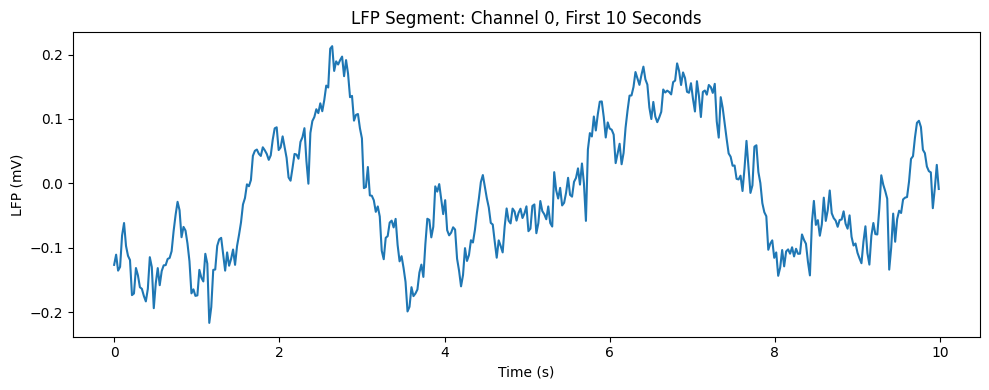

In [2]:
import h5py
import pynwb
import remfile
import numpy as np
import matplotlib.pyplot as plt

# File path and asset retrieval
lfp_asset_path = "sub-699241/sub-699241_ses-1318772854_probe-1_ecephys.nwb"

with DandiAPIClient() as client:
    dandiset = client.get_dandiset(dandiset_id, dandiset_version)
    lfp_asset = next(dandiset.get_assets_by_glob(lfp_asset_path))
    lfp_url = lfp_asset.download_url

# Stream the file remotely and open with pynwb
remote_file = remfile.File(lfp_url)
h5_file = h5py.File(remote_file, 'r')
io = pynwb.NWBHDF5IO(file=h5_file, load_namespaces=True)
nwb_lfp = io.read()

# Access LFP data for probe 1, channel 0
lfp = nwb_lfp.acquisition['probe_1_lfp'].electrical_series['probe_1_lfp_data']
channel_index = 0
# Extract data segment where timestamp < 10,000 ms (first 10 seconds)
timestamps = lfp.timestamps[:]
mask = timestamps < 10000  # timestamps are in ms
lfp_data = lfp.data[:np.sum(mask), channel_index]
time_sec = timestamps[mask] / 1000.0  # convert ms to s

# Plot the LFP segment
plt.figure(figsize=(10, 4))
plt.plot(time_sec, lfp_data * 1e3)
plt.xlabel('Time (s)')
plt.ylabel('LFP (mV)')
plt.title('LFP Segment: Channel 0, First 10 Seconds')
plt.tight_layout()
plt.show()

## Spike Raster Plot for the First 10 Units (20–30 s Window)

We next visualize spike times for the first 10 spike-sorted units from the ogen file. Here, we use a time window (20–30 s) where spikes are present. The proper way to retrieve spike times is `nwb.units.spike_times_index[i]`.

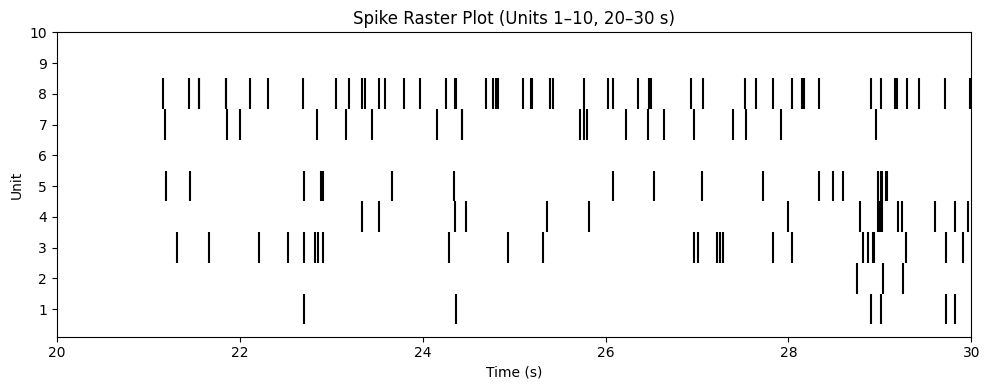

In [3]:
# File path for ogen file
ogen_asset_path = "sub-699241/sub-699241_ses-1318772854_ogen.nwb"

with DandiAPIClient() as client:
    dandiset = client.get_dandiset(dandiset_id, dandiset_version)
    ogen_asset = next(dandiset.get_assets_by_glob(ogen_asset_path))
    ogen_url = ogen_asset.download_url

remote_file_ogen = remfile.File(ogen_url)
h5_file_ogen = h5py.File(remote_file_ogen, 'r')
io_ogen = pynwb.NWBHDF5IO(file=h5_file_ogen, load_namespaces=True)
nwb_ogen = io_ogen.read()

# Retrieve spike times for first 10 units and plot 20-30s window
num_units = 10
spike_times_list = [nwb_ogen.units.spike_times_index[i] for i in range(num_units)]

window_start, window_end = 20, 30
spikes_window = [st[(st >= window_start) & (st < window_end)] for st in spike_times_list]

plt.figure(figsize=(10, 4))
for i, st in enumerate(spikes_window):
    plt.vlines(st, i + 0.5, i + 1.5, color='black')
plt.xlabel('Time (s)')
plt.ylabel('Unit')
plt.yticks(np.arange(1, num_units + 1), np.arange(1, num_units + 1))
plt.title("Spike Raster Plot (Units 1–10, 20–30 s)")
plt.xlim(window_start, window_end)
plt.tight_layout()
plt.show()

## Pupil Area Over a 30-Second Window

This segment visualizes the animal's pupil area (from `pupil_tracking`) over a 30-second window.

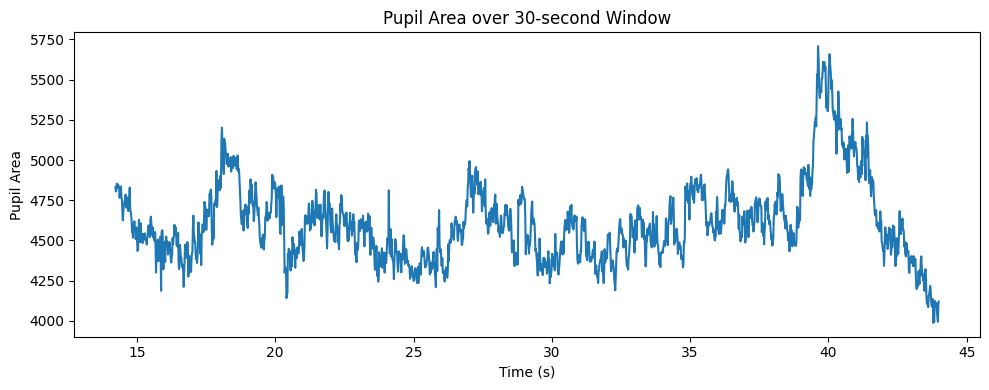

In [4]:
# Access eye tracking data
eyetrack = nwb_ogen.acquisition['EyeTracking']
pupil = eyetrack.spatial_series['pupil_tracking']
pupil_area = pupil.area[:]
pupil_timestamps = pupil.timestamps[:]
# Display a 30-second segment, e.g., 14–44 s if available (as seen in chat)
mask = (pupil_timestamps >= 14) & (pupil_timestamps < 44)
plt.figure(figsize=(10, 4))
plt.plot(pupil_timestamps[mask], pupil_area[mask])
plt.xlabel('Time (s)')
plt.ylabel('Pupil Area')
plt.title('Pupil Area over 30-second Window')
plt.tight_layout()
plt.show()

## Unit Properties: Table and Summary Statistics

Here, we explore several spike-sorted unit properties for the ogen file (firing rate, SNR, amplitude, isolation, etc.).

In [5]:
import pandas as pd

units = nwb_ogen.units
to_show = ['firing_rate', 'quality', 'isolation_distance', 'snr', 'amplitude', 'waveform_duration']
avail = [c for c in units.colnames if c in to_show]
unit_df = units.to_dataframe()[avail]

# Show first 10 units and summary of available properties
print("First 10 units (selected properties):")
print(unit_df.head(10))
print("\nSummary statistics:")
print(unit_df.describe(include='all').transpose())

First 10 units (selected properties):
         snr quality  waveform_duration   amplitude  isolation_distance  \
id                                                                        
15  4.266568    good           0.357119   79.209585           35.342475   
16  3.548613    good           0.370854  159.862170           42.580614   
17  2.785697    good           0.398325  111.336615           40.738294   
18  2.814532    good           0.315913  115.052340           41.385245   
19  2.896491    good           0.315913  113.427210           33.658400   
20  1.794729    good           0.315913   73.619910           68.527454   
21  2.855068    good           0.425796  117.041925           49.570874   
22  2.872371    good           0.425796  125.039655           81.055900   
23  3.965438    good           0.384590  163.542405           74.633663   
24  1.848058    good           0.398325   71.763315           76.645478   

    firing_rate  
id               
15     0.603134  
16     

## Stimulus Event Times: Tick Plot ("Raster") for a 1-Second Zoom

Stimulus events can be very frequent and hard to distinguish in a 10s window. Here we zoom in to a 1-second window so you can see individual events.

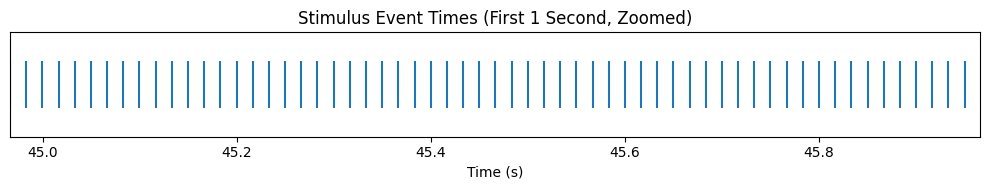

In [6]:
# Retrieve stimulus event times
stimulus = nwb_ogen.processing['stimulus']
stim_timestamps = stimulus.data_interfaces['timestamps'].data[:]

# Pick the first second of events for visual clarity
start_time = stim_timestamps[0]
window_1s = (stim_timestamps >= start_time) & (stim_timestamps < start_time + 1)
window_times_1s = stim_timestamps[window_1s]

plt.figure(figsize=(10, 2))
plt.eventplot(window_times_1s, orientation='horizontal', colors='tab:blue', lineoffsets=0.5, linelengths=0.8)
plt.xlabel('Time (s)')
plt.title('Stimulus Event Times (First 1 Second, Zoomed)')
plt.yticks([])
plt.xlim(start_time, start_time + 1)
plt.tight_layout()
plt.show()

## Next Steps

- This notebook provides elementary code blocks to get started exploring Dandiset 000563.
- You can adapt the code to load other probes/channels, analyze more behavioral/neural data, or explore more stimulus types.
- Please review the NWB documentation and dataset descriptions for deeper or custom re-analyses.

**Always validate outputs before publishing or drawing scientific conclusions!**